# Multi-class Classification and Neural Networks
This notebook presents concepts and implementations of Multi-class Classification and Neural Networks. 
It also has some experiments comparing my implementation with [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation and other experiments based on Programming Exercise 3 of course [Machine Learning on Coursera](https://www.coursera.org/learn/machine-learning).

## 1. Multiclass Classification

To classify data into multiple classes, our hypothesis will return a vector of values with 0's and 1's. For example, for a problem with four classes, $y$ will be:

$y^{(i)} = \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix}, 
\begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \end{bmatrix},
\begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix},
\begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}$

### 1.1 Multiclass Logistic Regression

The implementation is equal to binary logistic regression but now we will train multiple regularized logistic regression classifier, one for each of $K$ classes in the input dataset. The matrix $\Theta$ will have the parameters learned for all the classes, each row corresponds to the parameters for one class. 

#### Cost function and gradient

In [1]:
import numpy as np
def sigmoid(z):
    z = np.array(z)
    return 1 / (1+np.exp(-z))

In [2]:
def lr_cost_function(theta, X, y, lambda_reg):
    m = y.shape[0]
    theta = theta[:, np.newaxis] 
    h = sigmoid(X.dot(theta))
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h))) + (lambda_reg/(2*m)) * np.sum(theta[1:]**2)

    diff_hy = h - y
    grad = (1/m) * diff_hy.T.dot(X) + ((lambda_reg/m) * theta.T)
    grad[0, 0] = (1/m) * diff_hy.T.dot(X[:, 0])

    return J, grad

#### Train the model (learning $\Theta$)

In [3]:
import scipy.optimize as opt
def one_vs_all(X, y, num_labels, lambda_reg):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n+1))    
    X = np.hstack((np.ones((m,1)), X))
    
    for i in range(num_labels):
        initial_theta = np.zeros(shape=(n+1))
        opt_results = opt.minimize(lr_cost_function, initial_theta, args=(X, y==i+1, lambda_reg), 
                                   method='TNC', jac=True, options={'maxiter':50})
        all_theta[i, :] = opt_results['x']
        
    return all_theta

#### Predict

In [4]:
def predict_one_vs_all(all_theta, X):
    m, n = X.shape
    X = np.hstack((np.ones((m,1)),X))
    
    pred = sigmoid(X.dot(all_theta.T))
    y_pred = np.argmax(pred, axis=1)+1
    return y_pred

### 1.2 Experiments

#### Imports

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Dataset

> "You will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. The second part of the training set is a 5000-dimensional vector y that contains labels for the training set."

In [6]:
import scipy.io
mat = scipy.io.loadmat('data/ex3data1.mat')
mat

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

#### Data Visualization

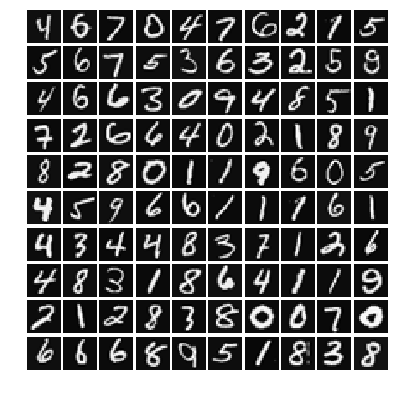

In [7]:
import numpy as np
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
indexes = np.random.choice(5000, rows*cols)
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(mat['X'][indexes[count]].reshape(20,20).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

#### Testing Cost Function

In [8]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.hstack((np.ones((5,1)), (np.arange(1,16).reshape(3,5)).T / 10))
y_t = np.array([1, 0, 1, 0, 1]).reshape(5, -1)
lambda_t = 3

In [9]:
J, grad = lr_cost_function(theta_t, X_t, y_t, lambda_t)
print('Cost:', J)
print('Expected cost: 2.534819')
print('Gradients:')
print(grad.T)
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003')

Cost: [[ 2.5348194]]
Expected cost: 2.534819
Gradients:
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


#### One-vs-all Classification

In [10]:
lambda_r = 0.1
num_labels = 10
all_theta = one_vs_all(mat['X'], mat['y'], num_labels, lambda_r)

In [11]:
y_pred = predict_one_vs_all(all_theta, mat['X'])
accuracy = np.mean(y_pred == mat['y'].T)
f'Train accuracy: {accuracy * 100}'

'Train accuracy: 95.39999999999999'

Similar code using Scikit-Learn:

In [12]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='newton-cg', max_iter=50, multi_class='ovr')
log_reg.fit(mat['X'], mat['y'].T[0])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=None,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
log_reg.score(mat['X'], mat['y'].T[0])

0.9446

## 2. Neural Networks

Performing linear regression with a complex set of data with many features is very unwieldy. Neural networks offers an alternate way to perform machine learning when we have complex hypotheses with many features.

### 2.1 Neurons and the Brain

* Neural networks are limited imitations of how our own brains work.
* There is evidence that the brain uses only one "learning algorithm" for all its different functions.

### 2.2 Model Representation

* input features $x_1 ... x_n$ : input nodes, input layer, layer 1
    * $x_0$ input node called "bias unit", always equal to 1
* output : result of hypothesis function, output layer
* same logistic function as in classification $\frac{1}{1+e^{-\theta^Tx}}$, called activation function
* the $\theta$ parameters are called "weights"
* intermediate layers of nodes between the input and output layers are called "hidden layers"
    * nodes of hidden layers are called "activation units" and labeled as $a_0^2 ... a_n^2$

$a_i^{(j)}$ = activation unit $i$ in layer $j$

$\Theta^{(j)}$ = matrix of weights controlling function mapping from layer $j$ to layer $j+1$
* If network has $s_j$ units in layer $j$ and $s_{j+1}$ units in layer $j+1$, then $\Theta^{(j)}$ will be of dimension $s_{j+1} \times (s_j + 1)$

A simple representation: $ \begin{bmatrix}x_0 \\ x_1 \\ x_2 \\ x_3 \end{bmatrix} \rightarrow \begin{bmatrix}a_1^{(2)} \\ a_2^{(2)} \\ a_3^{(2)} \end{bmatrix} \rightarrow h_\theta(x)$

The values for each of the activation nodes:

$a_1^{(2)} = g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3)$

$a_2^{(2)} = g(\Theta_{20}^{(1)}x_0 + \Theta_{21}^{(1)}x_1 + \Theta_{22}^{(1)}x_2 + \Theta_{23}^{(1)}x_3)$

$a_3^{(2)} = g(\Theta_{30}^{(1)}x_0 + \Theta_{31}^{(1)}x_1 + \Theta_{32}^{(1)}x_2 + \Theta_{33}^{(1)}x_3)$

$h_\Theta(x) = a_1^{(3)} = g(\Theta_{10}^{(2)}a_0^{(2)} + \Theta_{11}^{(2)}a_1^{(2)} + \Theta_{12}^{(2)}a_2^{(2)} + \Theta_{13}^{(2)}a_3^{(2)})$

### 2.3 Experiments

#### Dataset
It's the same dataset of previous experiment.

#### Data Visualization

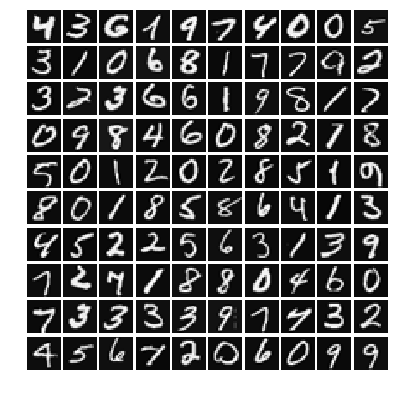

In [14]:
import numpy as np
rows = 10
cols = 10
fig = plt.figure(figsize=(5,5))
indexes = np.random.choice(5000, rows*cols)
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        ax1 = fig.add_subplot(rows, cols, count+1)
        ax1.imshow(mat['X'][indexes[count]].reshape(20,20).T, cmap='gray')
        ax1.autoscale(False)
        ax1.set_axis_off()
        count+=1
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()

#### Loading Saved Neural Network Parameters

In [15]:
mat_weights = scipy.io.loadmat('data/ex3weights.mat')

#### Feedforward Propagation and Prediction

In [16]:
def predict_nn(theta1, theta2, X):
    m, n = X.shape
    X = np.hstack((np.ones((m,1)),X))
    
    a2 = sigmoid(X.dot(theta1.T))
    a3 = sigmoid(np.hstack((np.ones((m,1)),a2)).dot(theta2.T))
    y_pred = np.argmax(a3, axis=1)+1
    
    return y_pred

In [17]:
y_pred = predict_nn(mat_weights['Theta1'], mat_weights['Theta2'], mat['X'])
accuracy = np.mean(y_pred == mat['y'].T)
f'Train accuracy: {accuracy * 100}'

'Train accuracy: 97.52'

Similar code using Scikit-Learn:

In [18]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(25,), activation='logistic')
nn.fit(mat['X'], mat['y'].T[0])

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [19]:
nn.score(mat['X'], mat['y'].T[0])

0.98780000000000001

#### Visualizating some results:

Neural Network Prediction: [7]


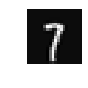

Neural Network Prediction: [6]


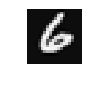

Neural Network Prediction: [6]


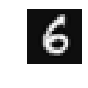

Neural Network Prediction: [1]


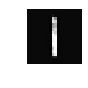

Neural Network Prediction: [9]


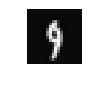

Neural Network Prediction: [8]


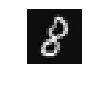

Neural Network Prediction: [5]


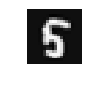

Neural Network Prediction: [5]


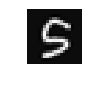

Neural Network Prediction: [8]


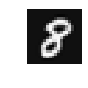

In [20]:
rows = 3
cols = 3
indexes = np.random.choice(5000, rows*cols)
count = 0
for i in range(0,rows):
    for j in range(0,cols):
        fig = plt.figure(figsize=(1,1))
        plt.imshow(mat['X'][indexes[count]].reshape(20,20).T, cmap='gray')
        pred = predict_nn(mat_weights['Theta1'], mat_weights['Theta2'], mat['X'][indexes[count], :].reshape(1,-1))
        print('Neural Network Prediction:', pred)
        count+=1
        plt.axis('off')
        plt.show()